In this notebook, we will play with the models.

In [2]:
import torch
from torchvision.models import resnet18, resnet50
import model_utils
import plotter
import data
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
import importlib

model_utils.fix_random(42)

In [11]:
train_data = data.CIFAKEDataset(root_dir="data/CIFAKE", split="train")
test_data = data.CIFAKEDataset(root_dir="data/CIFAKE", split="test")

In [12]:
# import model to finetune
ft_resnet18 = resnet18(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resnet18, num_classes=1)
device = model_utils.get_device()
print(f"using {device} device")
ft_resnet18.to(device)

LEARNING_RATE = 3e-4
EPOCHS = 10
BATCH_SIZE = 128

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, pin_memory=True, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, pin_memory=True)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(ft_resnet18.fc.parameters(), lr=LEARNING_RATE)

dataloaders = (train_dataloader, test_dataloader)

using cuda device


In [5]:
# N.B.: the loss displayed is the testing loss! (not train unless specified)
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resnet18, "FTResNet18", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

c:\Users\ASUS\Desktop\ethics_2\ethics_project2\model_utils.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [6]:
model_utils.test(test_dataloader, ft_resnet18, loss_fn, device)

Test Error:
Accuracy: 74.6%, Avg loss: 0.531957 



(0.5319565451069243, tensor(0.7458, device='cuda:0'))

<class 'list'> <class 'list'>
[tensor(0.5875, device='cuda:0'), tensor(0.6702, device='cuda:0'), tensor(0.7031, device='cuda:0'), tensor(0.7198, device='cuda:0'), tensor(0.7285, device='cuda:0'), tensor(0.7332, device='cuda:0'), tensor(0.7385, device='cuda:0'), tensor(0.7426, device='cuda:0'), tensor(0.7449, device='cuda:0'), tensor(0.7469, device='cuda:0')] [tensor(0.6379, device='cuda:0'), tensor(0.6859, device='cuda:0'), tensor(0.7145, device='cuda:0'), tensor(0.7229, device='cuda:0'), tensor(0.7319, device='cuda:0'), tensor(0.7384, device='cuda:0'), tensor(0.7458, device='cuda:0'), tensor(0.7455, device='cuda:0'), tensor(0.7527, device='cuda:0'), tensor(0.7490, device='cuda:0')]


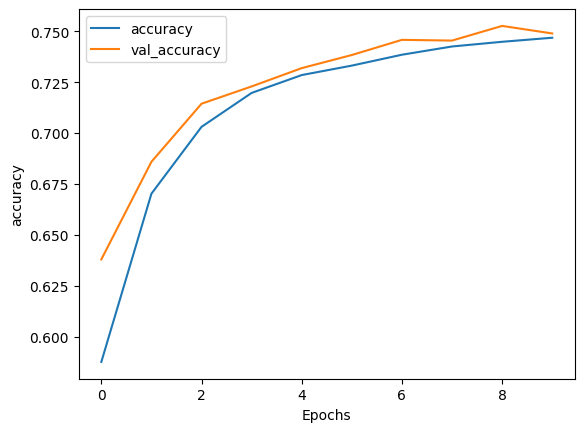

In [17]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

ResNet50 with AdamW

In [21]:
ft_resent50 = resnet50(weights='IMAGENET1K_V1')
model_utils.prepare_for_ft(ft_resent50, num_classes=1)
ft_resent50.to(device)

optimizer = torch.optim.AdamW(ft_resent50.fc.parameters(), lr=LEARNING_RATE)

In [22]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resent50, "FTResNet50", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

c:\Users\ASUS\Desktop\ethics_2\ethics_project2\model_utils.py:140: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weight_filename))


In [23]:
model_utils.test(test_dataloader, ft_resent50, loss_fn, device)

Test Error:
Accuracy: 82.7%, Avg loss: 0.388036 



(0.3880356218025183, tensor(0.8271, device='cuda:0'))

<class 'list'> <class 'list'>
[tensor(0.7677, device='cuda:0'), tensor(0.8009, device='cuda:0'), tensor(0.8088, device='cuda:0'), tensor(0.8155, device='cuda:0'), tensor(0.8170, device='cuda:0'), tensor(0.8195, device='cuda:0'), tensor(0.8219, device='cuda:0'), tensor(0.8232, device='cuda:0'), tensor(0.8241, device='cuda:0'), tensor(0.8239, device='cuda:0')] [tensor(0.8005, device='cuda:0'), tensor(0.8093, device='cuda:0'), tensor(0.8178, device='cuda:0'), tensor(0.8199, device='cuda:0'), tensor(0.8226, device='cuda:0'), tensor(0.8227, device='cuda:0'), tensor(0.8275, device='cuda:0'), tensor(0.8271, device='cuda:0'), tensor(0.8251, device='cuda:0'), tensor(0.8295, device='cuda:0')]


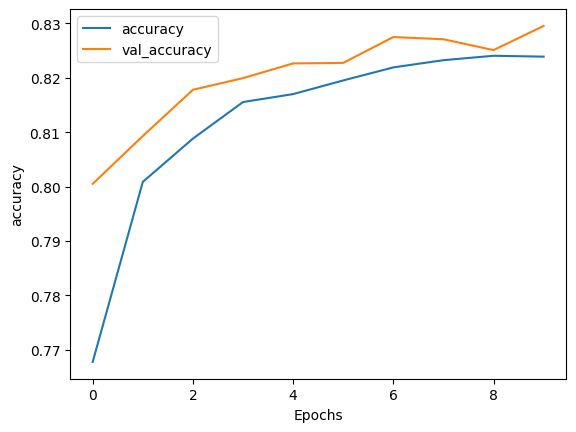

In [25]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

GradCAM test

In [24]:
import xai

xai.device = device

100%|██████████| 64/64 [00:01<00:00, 53.17it/s]


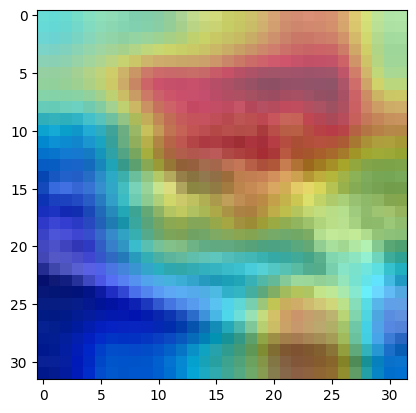

In [26]:
xai.explain_gradcam_single_image(train_dataloader, ft_resent50, [ft_resent50.layer1, ft_resent50.layer2, ft_resent50.layer3, ft_resent50.layer4])

100%|██████████| 1000/1000 [00:01<00:00, 854.69it/s]


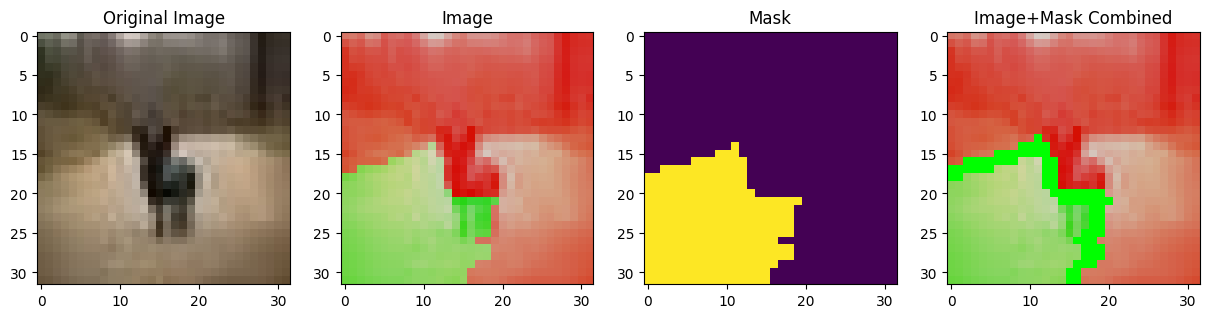

In [29]:
xai.explain_lime_single_image(train_dataloader, ft_resent50)

TODO: fix lime. I think the problem is in the batch_predict function, which does not give the right prediction

#### Better finetuning of resnet
The classification head has been already finetuned.
time to finetune the feauture extractor.

In [25]:
for param in ft_resent50.parameters():
    param.requires_grad = True


optimizer = torch.optim.AdamW(ft_resent50.parameters(), lr=LEARNING_RATE)

In [ ]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, ft_resent50, "FTResNet50_beefy", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=True)

Epoch 1/10
-------------------------------
training loss: 0.197180, train accuracy: 4.32  [ 5120/100000]
training loss: 0.117130, train accuracy: 9.06  [10240/100000]
training loss: 0.147261, train accuracy: 13.83  [15360/100000]
training loss: 0.121713, train accuracy: 18.60  [20480/100000]
training loss: 0.138992, train accuracy: 23.45  [25600/100000]
training loss: 0.132689, train accuracy: 28.30  [30720/100000]
training loss: 0.083764, train accuracy: 33.15  [35840/100000]
training loss: 0.197115, train accuracy: 38.02  [40960/100000]
training loss: 0.099501, train accuracy: 42.91  [46080/100000]
training loss: 0.280323, train accuracy: 47.80  [51200/100000]
training loss: 0.079485, train accuracy: 52.70  [56320/100000]
training loss: 0.102742, train accuracy: 57.58  [61440/100000]
training loss: 0.128850, train accuracy: 62.50  [66560/100000]
training loss: 0.109865, train accuracy: 67.39  [71680/100000]
training loss: 0.080837, train accuracy: 72.29  [76800/100000]
training loss:

In [ ]:
model_utils.test(test_dataloader, ft_resent50, loss_fn, device)

In [ ]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts 
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

### Modified ResNET (3 LL)

In [15]:
importlib.reload(model_utils)

<module 'model_utils' from 'c:\\Users\\ASUS\\Desktop\\ethics_2\\ethics_project2\\model_utils.py'>

In [16]:
mod_resnet50 = model_utils.ModifiedResNet(original_resnet=resnet50(weights='IMAGENET1K_V1'))

In [19]:
mod_resnet50.prepare_for_ft()
mod_resnet50.to(device)

ModifiedResNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2

In [20]:
artifacts = model_utils.train(dataloaders, loss_fn, optimizer, mod_resnet50, "ModResNet50", BATCH_SIZE, EPOCHS, loss_thresh=2.5, force_train=False)

Epoch 1/10
-------------------------------
training loss: 0.687288, train accuracy: 2.79  [ 5120/100000]
training loss: 0.689947, train accuracy: 5.55  [10240/100000]
training loss: 0.690713, train accuracy: 8.26  [15360/100000]
training loss: 0.692957, train accuracy: 10.98  [20480/100000]
training loss: 0.690356, train accuracy: 13.71  [25600/100000]
training loss: 0.690464, train accuracy: 16.42  [30720/100000]
training loss: 0.692770, train accuracy: 19.15  [35840/100000]
training loss: 0.692583, train accuracy: 21.86  [40960/100000]
training loss: 0.690638, train accuracy: 24.63  [46080/100000]
training loss: 0.691715, train accuracy: 27.36  [51200/100000]
training loss: 0.691525, train accuracy: 30.02  [56320/100000]
training loss: 0.692618, train accuracy: 32.74  [61440/100000]
training loss: 0.691711, train accuracy: 35.43  [66560/100000]
training loss: 0.690679, train accuracy: 38.10  [71680/100000]
training loss: 0.692225, train accuracy: 40.86  [76800/100000]
training loss: 

KeyboardInterrupt: 

In [ ]:
if artifacts != None:
    losses, train_accs, test_accs = artifacts
    plotter.plot_metrics((train_accs, test_accs), "accuracy")

In [ ]:
# testing adam performance
optimizer = torch.optim.Adam(mod_resnet50.parameters(), lr=0.001, weight_decay=0.0001)